<a href="https://colab.research.google.com/github/sudevansujit/IMDB_Sentiment_Analysis/blob/master/IMDB_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
IMDB Sentiment Analysis

**IMDB** Sentiment **Analysis**

In [1]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':'1mBFPNOxy_O4mh8DWPD_4FNzDXmpJ0fn-'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Cleaned_IMDB.csv')

In [9]:
import pandas as pd
import numpy as np

data = pd.read_csv('Cleaned_IMDB.csv', index_col = 'Unnamed: 0')
data.head()

,Texts,Labels,Text
18857,right from the start you see that anchors awei...,1,right start see anchors aweigh great comedy ge...
17585,i love and admire the farrelly brothers how co...,1,love admire farrelly brothers come got see gre...
13930,considered by almost all the critics to be the...,1,considered almost critics best johnny weissmul...
16709,for real film people this film is a must since...,1,real film people film must since works perfect...
2919,it s like a bad s tv show got loose and tried ...,0,like bad television show got loose tried becom...


In [10]:
# Shuffling DataFrame
from sklearn.utils import shuffle
data = shuffle(data)
data.head()

,Texts,Labels,Text
214,with this film bunuel manipulates the viewer w...,0,film bunuel manipulates viewer film might stat...
3624,this movie is pure guano mom always said if yo...,0,movie pure guano mom always said cannot say an...
12292,this is the kind of movie you regret you put i...,0,kind movie regret put vcr weird bad rip versio...
24249,i have found this movie available for streamin...,1,found movie available streaming netflix though...
9905,i usually start by relaying the premise of the...,0,usually start relaying premise film anyone mak...


In [11]:
labels = list(data['Labels'].values)
texts = list(data['Text'].values)

In [12]:
texts[0]

'film bunuel manipulates viewer film might stating clearly film work one objectivity obviously one reason many scenes shot pure chance obvious set ups poor goat accidently falls cliff actually see gun smoke right screen another concealing one important information hurdes people way specific reason hinted film goitre sickness caused lack iodine salt goitre cause cretinism bunuel took time make research heck checked cretinism medical dictionary would found goitre might ended telling truth people still doubtfully instead film judges constantly talking cretins dramatizing action setting scenes create spectacle unacceptable documentarist claims work mighty objectivity bunuel talks time film letting one word people filming talks even judges piece flawed roots ideology real shame considered great film'

In [13]:
labels[0]

0

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print("Unique Words", len(word_index))

Unique Words 74073


In [15]:
data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)
print("Shape of data tensor ", data.shape)
print("Shape of label tensor ", labels.shape)

Shape of data tensor  (25000, 100)
Shape of label tensor  (25000,)


In [16]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

In [19]:
X_train = data[:training_samples]
y_train = labels[:training_samples]

X_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

In [18]:
downloaded = drive.CreateFile({'id':'1DG-WejzQ1mP-RyGeEdGnfLXBdiR-i1V-'}) # replace the id with id of file you want to access
downloaded.GetContentFile('glove.6B.100d.txt')

In [20]:
embeddings_index = {}
f = open( 'glove.6B.100d.txt', encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
    
f.close()
    
print("Found %s word vectors" % len(embeddings_index))

Found 400000 word vectors


In [21]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data = (X_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 118ms/step - loss: 0.8966 - acc: 0.5200 - val_loss: 0.6913 - val_acc: 0.5059
Epoch 2/10
7/7 [==============================] - 1s 77ms/step - loss: 0.5851 - acc: 0.7250 - val_loss: 0.7608 - val_acc: 0.5025
Epoch 3/10
7/7 [==============================] - 1s 76ms/step - loss: 0.4224 - acc: 0.7950 - val_loss: 1.2666 - val_acc: 0.5011
Epoch 4/10
7/7 [==============================] - 1s 76ms/step - loss: 0.2662 - acc: 0.9100 - val_loss: 0.9456 - val_acc: 0.5086
Epoch 5/10
7/7 [==============================] - 1s 72ms/step - loss: 0.1286 - acc: 0.9750 - val_loss: 0.6748 - val_acc: 0.6121
Epoch 6/10
7/7 [==============================] - 1s 74ms/step - loss: 0.0566 - acc: 1.0000 - val_loss: 0.7686 - val_acc: 0.5863
Epoch 7/10
7/7 [==============================] - 1s 72ms/step - loss: 0.0325 - acc: 1.0000 - val_loss: 0.6917 - val_acc: 0.6216
Epoch 8/10
7/7 [==============================] - 1s 74ms/step - loss: 0.0169 - acc: 1.0000 - va

In [24]:
#model.save_weights('pre_trained_glove_model.h5')

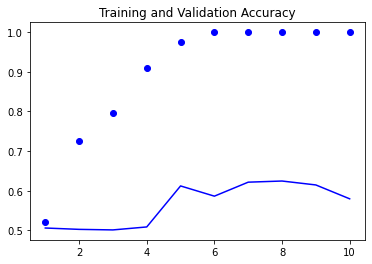

In [23]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label = 'Training Acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation Acc')
plt.title("Training and Validation Accuracy")
plt.show()

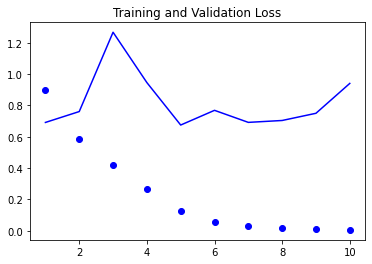

In [25]:
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title("Training and Validation Loss")
plt.show()

In [26]:
#Training the same model without pretraining word embedding
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model=Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy', metrics = ['acc'])
history=model.fit(X_train, y_train, epochs=10,batch_size = 32, validation_data = (X_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 102ms/step - loss: 0.7034 - acc: 0.4550 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 2/10
7/7 [==============================] - 1s 85ms/step - loss: 0.5860 - acc: 0.8900 - val_loss: 0.6932 - val_acc: 0.5096
Epoch 3/10
7/7 [==============================] - 1s 92ms/step - loss: 0.4458 - acc: 0.9900 - val_loss: 0.7255 - val_acc: 0.5077
Epoch 4/10
7/7 [==============================] - 1s 102ms/step - loss: 0.2378 - acc: 0.9900 - val_loss: 0.7179 - val_acc: 0.5209
Epoch 5/10
7/7 [==============================] - 1s 102ms/step - loss: 0.1091 - acc: 1.0000 - val_loss: 0.6915 - val_acc: 0.5396
Epoch 6/10
7/7 [==============================] - 1s 97ms/step - loss: 0.0504 - acc: 1.0000 - val_loss: 0.7357 - val_acc: 0.5210
Epoch 7/10
7/7 [==============================] - 1s 93ms/step - loss: 0.0276 - acc: 1.0000 - val_loss: 0.6957 - val_acc: 0.5457
Epoch 8/10
7/7 [==============================] - 1s 102ms/step - loss: 0.0155 - acc: 1.0000 -